# **DNA Splice-Junction Classification Pipeline**

## **Import libraries**

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## **Data Acquisition & Cleaning**

### Fetch the dataset and transform the raw genomic strings into a format a machine learning model can understand (individual columns for each nucleotide position).

In [27]:
# Fetch dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data"
columns = ['Class', 'Instance_Name', 'Sequence']
df = pd.read_csv(url, names=columns, skipinitialspace=True)
df

,Class,Instance_Name,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...
...,...,...,...
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTTCTCTCCTCTTCTC...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAAGCACCTGGAGAAGC...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCGGTCCCCGGCCGCGGCC...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTGCTAGATAACCAAATTAA...


In [33]:
# FEATURE ENGINEERING: Converting the 60-character string into 60 individual columns bz machine learning can not handle strings of letters like sequence
X_raw = df['Sequence'].str.strip().apply(list).tolist() # convert series of strings to series of lists (pandas) and then to python lists
X_columns = [f'Pos_{i}' for i in range(1, 61)] # given column names
X_df = pd.DataFrame(X_raw, columns=X_columns)
X_df


# To list out the unique values of each column
#for col in X_df.columns:
    #print(col, X_df[col].unique())
# Found N and D, not part of nucleotides


## Data Cleaning: Replace ambiguous 'D' with 'N' and remove rows containing 'N'
X_df = X_df.replace({'D': 'N'}) # Replaced D to N
mask = ~X_df.isin(['N']).any(axis=1)

X_df_filtered = X_df[mask].reset_index(drop=True)
Y_df_filtered = df['Class'][mask].reset_index(drop=True)



print(X_df_filtered.shape)
print(Y_df_filtered.shape)

print(X_df_filtered.head())
print(Y_df_filtered.head())



(3177, 60)
(3177,)
  Pos_1 Pos_2 Pos_3 Pos_4 Pos_5 Pos_6 Pos_7 Pos_8 Pos_9 Pos_10  ... Pos_51  \
0     C     C     A     G     C     T     G     C     A      T  ...      A   
1     A     G     A     C     C     C     G     C     C      G  ...      G   
2     G     A     G     G     T     G     A     A     G      G  ...      C   
3     G     G     G     C     T     G     C     G     T      T  ...      G   
4     G     C     T     C     A     G     C     C     C      C  ...      C   

  Pos_52 Pos_53 Pos_54 Pos_55 Pos_56 Pos_57 Pos_58 Pos_59 Pos_60  
0      G      C      C      A      G      T      C      T      G  
1      T      G      C      C      C      C      C      G      C  
2      A      C      G      G      G      G      A      T      G  
3      G      T      T      T      T      C      C      C      C  
4      C      T      T      G      A      C      C      C      T  

[5 rows x 60 columns]
0    EI
1    EI
2    EI
3    EI
4    EI
Name: Class, dtype: object


## **Explicit Encoding**

### Machine Learning models require numbers. One-Hot Encoding for the DNA sequences and Label Encoding for the target classes.

In [34]:
# Encoding Features (X)
encoder = OneHotEncoder(sparse_output=False) # include both 1 and 0
X_encoded = encoder.fit_transform(X_df_filtered)
#fit(): Learns the categories from data (A, C, G, T for each column) Each nucleotide → 4 binary features (60*4=240 features)
#transform(): Converts data to one-hot encoded vectors using the learned categories, uses float numbers by default
feature_names = encoder.get_feature_names_out(X_df_filtered.columns)
feature_names
#Without X_df_filtered.columns → generic names (x0_A, x1_T, …)
#With X_df_filtered.columns → descriptive names (Pos_1_A, Pos_2_T, …)
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)



# Encoding Target (y)
# Sanity check:
print(df["Class"].unique())
label_enc = LabelEncoder() #This converts ['EI', 'IE', 'N'] into [0, 1, 2]
Y_encoded_df = label_enc.fit_transform(Y_df_filtered)
# Store the mapping to "decode" results later
class_names = label_enc.classes_


print(f"Class Mapping: {dict(zip(range(len(class_names)), class_names))}")
print(X_encoded_df.shape)
print(Y_encoded_df.shape)

#Key points
# Mask ensures rows with 'N' are removed consistently for both X and y.
# Reset index after filtering to avoid misalignment.
# One-hot encoding produces numeric ML-ready data.
# Label encoding converts categorical target into numeric labels.
# Shapes confirm everything matches.



['EI' 'IE' 'N']
Class Mapping: {0: 'EI', 1: 'IE', 2: 'N'}
(3177, 242)
(3177,)


## **Model Training & Feature Importance**

### **Random Forest Classifier** handles high-dimensional categorical data well and provides insight into which DNA positions are most critical for splicing.

## **No train–test split applied**

In [47]:
# Initial Training to check importance
clf_temp = RandomForestClassifier(random_state=42)
clf_temp.fit(X_encoded_df, Y_encoded_df)

# Identify most influential DNA positions
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': clf_temp.feature_importances_})
importance_df['Position'] = importance_df['Feature'].str.extract(r'(Pos_\d+)')
pos_importance = importance_df.groupby('Position')['Importance'].sum().sort_values(ascending=False)

print("Top 5 Influential DNA Positions:")
print(pos_importance.head(5))

#sanity check
X_encoded_df
X_encoded_df.shape
# Used the first nucleotide sequence / First row
X_encoded_df.iloc[[0]].shape  # prints sklearn expected 2D format ((n_samples (1), n_features(242)))
X_encoded_df.iloc[[0]]

# Prediction
print(clf_temp.predict(X_encoded_df.iloc[[0]]))  # sklearn expects in 2D format(n_samples (1), n_features(242))

# probability of prediction, before it arrives at the conclusion
print(clf_temp.predict_proba(X_encoded_df.iloc[[0]])) # .predict_proba always returns (n_samples,n_classes) in numpyarray format.

# To get the names of the classes instead as 0, 1 and 2
#Use LabelEncoder.classes_ after prediction to convert numbers to readable class names. Done in previous cell stored in a variable class_names
Y_pred_numeric = clf_temp.predict(X_encoded_df.iloc[[0]]) # predict function expects in 2D format
Y_pred_label = class_names[Y_pred_numeric]
Y_pred_label

Top 5 Influential DNA Positions:
Position
Pos_30    0.129558
Pos_29    0.101375
Pos_31    0.097734
Pos_32    0.095176
Pos_35    0.072779
Name: Importance, dtype: float64
[0]
[[0.82 0.12 0.06]]


array(['EI'], dtype=object)

## **Train-Test Split & Hyperparameter Tuning**

### To ensure the model generalizes to new data, we **split** the data. We then use **GridSearchCV**to find the optimal settings (hyperparameters) for the Random Forest.

In [45]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded_df, Y_encoded_df, test_size=0.2, random_state=42)

# Define the grid of parameters to test
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Systematic search for the best parameters
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [49]:
# For labels
X_test_pred_integer = grid_search.predict(X_test)
X_test_pred_labels = class_names[X_test_pred_integer]
X_test_pred_labels

array(['IE', 'IE', 'IE', 'EI', 'IE', 'EI', 'EI', 'N', 'EI', 'N', 'N', 'N',
       'EI', 'N', 'N', 'N', 'N', 'N', 'EI', 'EI', 'N', 'N', 'EI', 'EI',
       'N', 'EI', 'IE', 'N', 'IE', 'N', 'IE', 'N', 'EI', 'EI', 'IE', 'N',
       'EI', 'EI', 'IE', 'N', 'N', 'N', 'N', 'N', 'EI', 'IE', 'N', 'N',
       'EI', 'N', 'N', 'IE', 'N', 'N', 'IE', 'N', 'IE', 'EI', 'IE', 'EI',
       'EI', 'N', 'N', 'N', 'EI', 'N', 'N', 'IE', 'N', 'EI', 'N', 'N',
       'N', 'EI', 'N', 'EI', 'IE', 'IE', 'N', 'N', 'N', 'EI', 'IE', 'N',
       'EI', 'EI', 'N', 'N', 'EI', 'EI', 'N', 'N', 'EI', 'IE', 'IE', 'N',
       'EI', 'N', 'N', 'N', 'IE', 'EI', 'N', 'N', 'N', 'EI', 'EI', 'N',
       'IE', 'N', 'N', 'EI', 'N', 'N', 'EI', 'EI', 'IE', 'N', 'IE', 'EI',
       'N', 'EI', 'N', 'N', 'N', 'EI', 'N', 'N', 'EI', 'N', 'N', 'IE',
       'N', 'IE', 'IE', 'N', 'N', 'N', 'IE', 'EI', 'EI', 'EI', 'EI', 'EI',
       'EI', 'IE', 'N', 'IE', 'N', 'IE', 'N', 'EI', 'N', 'N', 'IE', 'EI',
       'EI', 'N', 'N', 'EI', 'IE', 'IE', 'N', 'N'

## **Final Evaluation**

### Evaluate the performance using a classification report, which shows Precision, Recall, and F1-Score for each of the three gene classes.

In [46]:
y_pred = best_model.predict(X_test)
print("\n--- Final Classification Report ---")
print(classification_report(Y_test, y_pred, target_names=class_names))

# Example Prediction on a single test case
sample = X_test.iloc[[0]]
pred_idx = best_model.predict(sample)[0]
probs = best_model.predict_proba(sample)

print(f"Sample Prediction: {class_names[pred_idx]}")
print(f"Probabilities (EI, IE, N): {probs}")


--- Final Classification Report ---
              precision    recall  f1-score   support

          EI       0.97      0.98      0.97       178
          IE       0.94      0.95      0.95       144
           N       0.97      0.97      0.97       314

    accuracy                           0.97       636
   macro avg       0.96      0.97      0.96       636
weighted avg       0.97      0.97      0.97       636

Sample Prediction: IE
Probabilities (EI, IE, N): [[0.19538095 0.70130952 0.10330952]]


## **DNA Feature Importance Visualization**

### Aggregates the importance of individual nucleotides (A, C, G, T) back into their original DNA positions (1–60). This helps to see if the model is focusing on the "Splicing Junction" (the boundary between exons and introns).

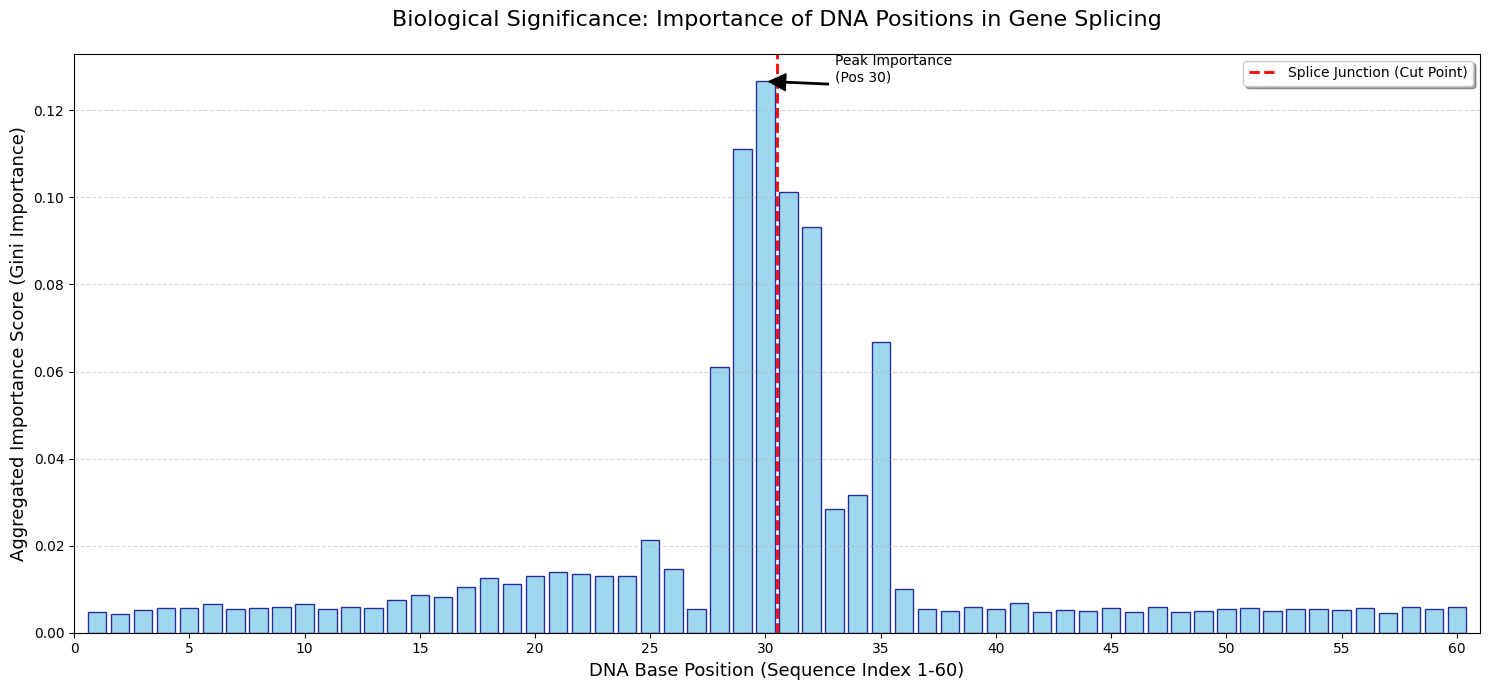

Feature importance plot generated. The model found Position 30 to be the most critical.


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract and Map Importances
# Take the importance weights from the trained Random Forest
importances = best_model.feature_importances_
feature_names = encoder.get_feature_names_out()

#  Aggregate Importance by DNA position
# Because One-Hot encoding split 1 position into 4 features, we sum them back up
pos_importances = {}
for name, imp in zip(feature_names, importances):
    # Extracts the number from 'Pos_1_A' -> '1'
    pos = name.split('_')[1]
    pos_importances[pos] = pos_importances.get(pos, 0) + imp

# Convert dictionary to a sorted list of positions and their summed values
sorted_positions = sorted(pos_importances.keys(), key=lambda x: int(x))
values = [pos_importances[p] for p in sorted_positions]
positions = [int(p) for p in sorted_positions]

# 3. Create the Visualization
plt.figure(figsize=(15, 7), dpi=100)
bars = plt.bar(positions, values, color='skyblue', edgecolor='navy', alpha=0.8)

# Highlight the Splice Junction (typically between position 30 and 31)
plt.axvline(x=30.5, color='red', linestyle='--', linewidth=2, label='Splice Junction (Cut Point)')

#  Labels
plt.title('Biological Significance: Importance of DNA Positions in Gene Splicing', fontsize=16, pad=20)
plt.xlabel('DNA Base Position (Sequence Index 1-60)', fontsize=13)
plt.ylabel('Aggregated Importance Score (Gini Importance)', fontsize=13)

# X-axis
plt.xticks(np.arange(0, 61, 5))
plt.xlim(0, 61)

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(frameon=True, shadow=True)

# Annotate the highest peak
max_val = max(values)
max_pos = positions[values.index(max_val)]
plt.annotate(f'Peak Importance\n(Pos {max_pos})',
             xy=(max_pos, max_val),
             xytext=(max_pos+3, max_val),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

print(f"Feature importance plot generated. The model found Position {max_pos} to be the most critical.")